### Przydzielona karta graficzna

In [0]:
!nvidia-smi

Tue Jun 18 12:20:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Import bibliotek

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
!pip install scikit-learn
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
import pandas as pd

from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

!pip install livelossplot
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


### Wczytanie tensorów X i y

In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [0]:
print(X.shape, y.shape)

### Zdefiniowanie parametrów augmentacji

0.0


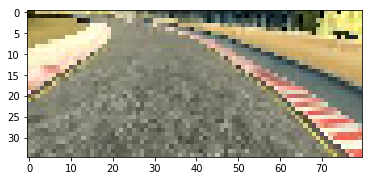

-0.42500000000000004


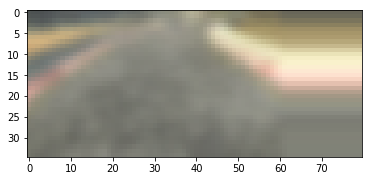

In [0]:
def augment(img, steering_angle):
  ##flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  
  ##blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 2))
  img = blurer.augment_image(img)
  
  ##contrast
  contrast = iaa.GammaContrast((0.5,2.0))
  img = contrast.augment_image(img)
  
  ##channel shuffle
  sh = iaa.ChannelShuffle(p=0.4)
  img = sh.augment_image(img)
  
  #snow = iaa.Snowflakes(density=(0.03,0.075))
  #img = snow.augment_image(img)
  
  ##fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  
  #translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={"x":tx}, mode = "edge")
  steering_angle += tx*0.025
  
  img = translater.augment_image(img)
    
  return img, steering_angle
  
plt.imshow(X[0])
print(y[0])
plt.show();
  
img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

### Podział danych X i y na zbiór treningowy i walidacyjny

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [0]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

### Augmentacja danych

In [0]:
Xgen=[]
ygen=[]


for i in range(X_train.shape[0]):
  img,angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

### Porównanie histogramów y przed i po augmentacji

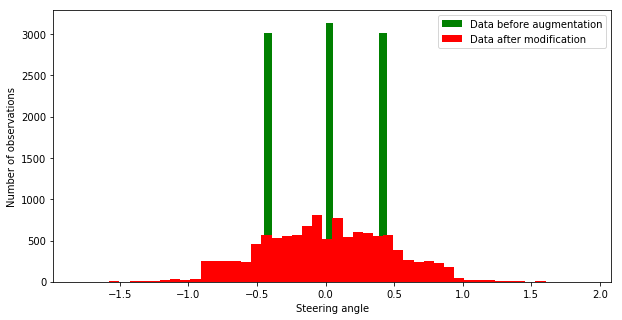

In [0]:
plt.figure(figsize=(10,5))
plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');
plt.xlabel('Steering angle');
plt.ylabel('Number of observations');
plt.legend(['Data before augmentation','Data after modification']);
plt.show()

In [0]:
print(Xgen.shape)
print(X_val.shape)

### Budowa architektury CNN

In [0]:
# VGG-16 ORYGINALNY
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape = input_shape, 
             name='normalize'),
      #obraz wejściowy 45x80
      
      Conv2D(64,(3,3), activation = 'relu'), #43x78
      Conv2D(64,(3,3), activation = 'relu'), #41x76
      MaxPooling2D(pool_size=(2,2)), #20x38

      Conv2D(128,(3,3), activation = 'relu'), #18x36
      Conv2D(128,(3,3), activation = 'relu'), #16x34
      MaxPooling2D(pool_size=(2,2)), #8x17
           
      Conv2D(256,(3,3), activation = 'relu'), #6x15
      Conv2D(256,(3,3), activation = 'relu'), #4x13
      Conv2D(256,(3,3), activation = 'relu'), #2x11
      MaxPooling2D(pool_size=(2,2)),
      
      Conv2D(512,(3,3), activation = 'relu'),
      Conv2D(512,(3,3), activation = 'relu'),
      Conv2D(512,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size=(2,2)),
      
      Conv2D(512,(3,3), activation = 'relu'),
      Conv2D(512,(3,3), activation = 'relu'),
      Conv2D(512,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size=(2,2)),
     
      Flatten(),
      
      Dense(4096, activation = 'relu'),
      Dense(4096, activation = 'relu'),
      Dense(100, activation = 'relu'),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)


### Kompilacja modelu

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 35, 80, 3)         0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 33, 78, 64)        1792      
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 31, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 15, 38, 64)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 13, 36, 128)       73856     
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 11, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 5, 17, 128)        0         
__________

### Trenowanie modelu

In [0]:
batch_size = 512
epochs =15

history = model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesCallback()],
         verbose=2)


### Predykcja y 

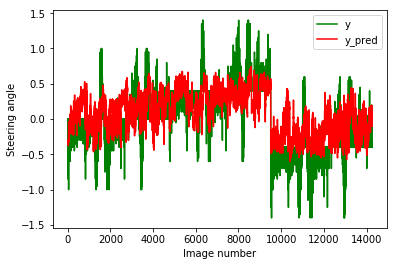

In [0]:
y_pred = model.predict(X)

plt.figure()
plt.plot(y,'g', y_pred,'r')
plt.xlabel('Image number');
plt.ylabel('Steering angle');
plt.legend(['y','y_pred']);

plt.show();

### Zapis modelu

In [0]:
model.save('cnn_model_vgg16mod_b512_e15_relu.h5')

### Własna modyfikacja modelu VGG

In [0]:
# VGG-16 MODYFIKACJA
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape = input_shape, 
             name='normalize'),
      #obraz wejściowy 45x80
      
      Conv2D(64,(3,3), activation = 'relu'), #43x78
      Conv2D(64,(3,3), activation = 'relu'), #41x76
      MaxPooling2D(pool_size=(2,2)), #20x38

      Conv2D(128,(3,3), activation = 'relu'), #18x36
      Conv2D(128,(3,3), activation = 'relu'), #16x34
      MaxPooling2D(pool_size=(2,2)), #8x17
           
      Conv2D(256,(3,3), activation = 'relu'), #6x15
      Conv2D(256,(3,3), activation = 'relu'), #4x13
      #Conv2D(256,(3,3), activation = 'relu'), #2x11
      #MaxPooling2D(pool_size=(2,2)),
      
      #Conv2D(512,(3,3), activation = 'relu'),
      #Conv2D(512,(3,3), activation = 'relu'),
      #Conv2D(512,(3,3), activation = 'relu'),
      #MaxPooling2D(pool_size=(2,2)),
      
      #Conv2D(512,(3,3), activation = 'relu'),
      #Conv2D(512,(3,3), activation = 'relu'),
      #Conv2D(512,(3,3), activation = 'relu'),
      #MaxPooling2D(pool_size=(2,2)),
     
      Flatten(),
      
      Dense(4096, activation = 'relu'),
      Dense(4096, activation = 'relu'),
      Dense(100, activation = 'relu'),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)

### Kompilacja modelu

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.summary()

W0618 12:39:06.827215 140431232288640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 35, 80, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 78, 64)        1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 38, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 36, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 17, 128)        0         
__________

### Trenowanie modelu

In [0]:
batch_size = 512
epochs =15

history = model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesCallback()],
         verbose=2)


### Predykcja y

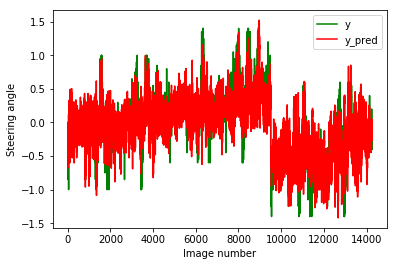

In [0]:
y_pred = model.predict(X)

plt.figure()
plt.plot(y,'g', y_pred,'r')
plt.xlabel('Image number');
plt.ylabel('Steering angle');
plt.legend(['y','y_pred']);

plt.show();

### Zapis modelu

In [0]:
model.save('cnn_model_vgg16mod_b512_e15_relu.h5')